In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
np.random.seed(42)

In [18]:
def log_likelihood_normal(data_point, p_11, p_12, p_21, p_22):
    """Calculate the log likelihood of the data given the transition probabilities."""
    return 0.5 * (((data_point - p_11) / p_12) ** 2 - np.log(2 * np.pi * p_12 ** 2)) + \
           -0.5 * (((data_point - p_21) / p_22) ** 2 + np.log(2 * np.pi * p_22 ** 2))

In [19]:
# Parameters are p11, p12, p21, p22
def cusum_detection_and_estimation(data, p_11, p_12, p_21, p_22, log_likelihood_ratio_func=log_likelihood_normal, threshold=5):
    cusum = np.zeros(len(data)+1)
    log_likelihood_sum = np.zeros(len(data)+1)

    for i in range(1, len(data)+1):
        log_likelihood_ratio = log_likelihood_ratio_func(data[i-1], p_11=p_11, p_12=p_12, p_21=p_21, p_22=p_22)
        cusum[i] = max(0, cusum[i-1] + log_likelihood_ratio)
        log_likelihood_sum[i] = log_likelihood_sum[i-1] + log_likelihood_ratio

        if cusum[i] > threshold:
            return np.argmin(log_likelihood_sum), i, log_likelihood_sum

    return np.inf, None, log_likelihood_sum

In [20]:
def cusum_detection_sequential(data, p_1, p_2, log_likelihood_ratio_func=log_likelihood_normal, threshold=5):
    """Perform CUSUM detection sequentially."""
    cusum = np.zeros(len(data)+1)
    log_likelihood_sum = np.zeros(len(data)+1)
    alarms = []
    num_alarms = 0

    for i in range(1, len(data)+1):
        log_likelihood_ratio = log_likelihood_ratio_func(data[i-1], p_1[num_alarms], p_2[num_alarms], p_1[num_alarms+1], p_2[num_alarms+1])
        cusum[i] = max(0, cusum[i-1] + log_likelihood_ratio)
        log_likelihood_sum[i] = log_likelihood_sum[i-1] + log_likelihood_ratio

        if cusum[i] > threshold:
            alarms.append(i)
            cusum[i] = 0
            num_alarms += 1
            if num_alarms >= len(p_1) - 1:
                break

    return alarms

In [21]:
def plot_cusum(data, estimated_change_times=None, alarms=[], actual_change_times=None):
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Data')
    if estimated_change_times is not None:
        plt.axvline(estimated_change_times, color='green', linestyle='--', label='Estimated Change Point(MLE)')
    for alarm in alarms:
        plt.axvline(alarm, color='orange', linestyle='--', label='Alarm')
    if actual_change_times is not None:
        for actual in actual_change_times:
            plt.axvline(actual, color='red', linestyle='--', label='Actual Change Point')
    plt.title('CUSUM Change Point Detection')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [22]:
# Single change point detection with MLE for change time estimation
data = np.concatenate([np.random.normal(0, 1, 50), np.random.normal(3, 1, 50)])
mu_1, sigma_1 = 0, 1
mu_2, sigma_2 = 3, 1
change_time, alarm, log_likelihood_sum = cusum_detection_and_estimation(data, mu_1, sigma_1, mu_2, sigma_2)

print(f"Estimated Change Time: {change_time}, Alarm Triggered at: {alarm}, Actual Change Time: 50")

Estimated Change Time: 50, Alarm Triggered at: 52, Actual Change Time: 50


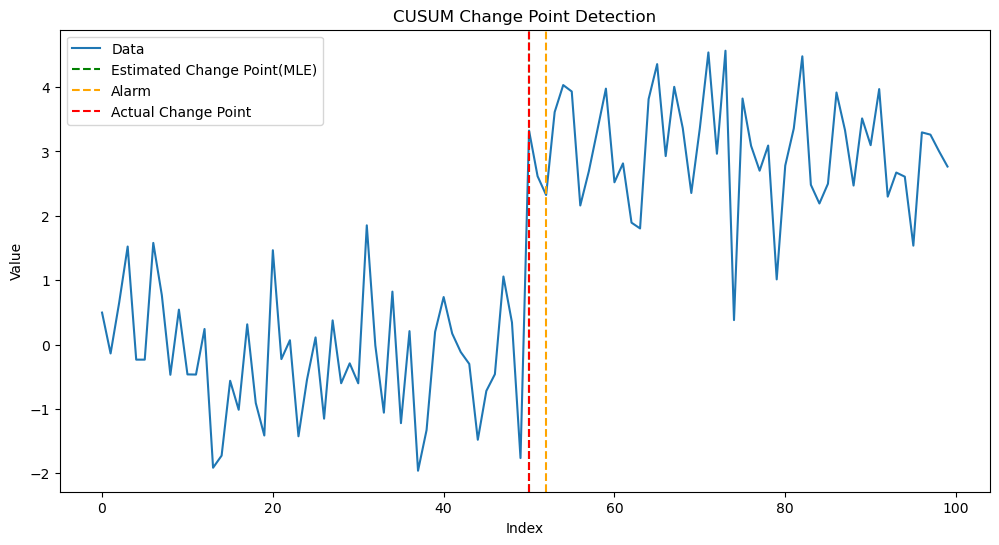

In [23]:
plot_cusum(data, estimated_change_times=[change_time], alarms=[alarm], actual_change_times=[50])

### Justification for MLE in i.i.d case:
- Estimation of change time as the point where log likelihood ration is minimum is based on the following
- The pre change distribution is given by $f_0$ and post change distribution is given by $f_1$
- The actual change time is denoted by $t_0$ and estimated change time is $\hat{t}_0$
- $X_1^n$ is the sequence that is observed
$$ \begin{equation}
\begin{split}
\mathcal{L}(t_0; X_1^n) & = \frac{\prod_{i=1}^{\hat{t}_0}f_0(X_i) \prod_{i=\hat{t}_0+1}^n f_1(X_i)}{\prod_{i=1}^nf_0(X_i)} \\
& = \frac{\prod_{i=\hat{t}_0+1}^n f_1(X_i)}{\prod_{i=\hat{t}_0+1}^nf_0(X_i)}
\end{split}
\end{equation}$$

- Now, note the following:
$$S_n = \sum_{i=1}^n \log \frac{f_1(X_i)}{f_0(X_i)}$$

- For a given n, finding $S_n - \min_{1\le k\le n}(S_k)$ is the same as:
$$S_n + \max_{1\le k\le n}(-S_k) \\
\implies \max_{1\le k\le n}(S_n - S_k) \\
\implies \max_{1\le k\le n}\left(\sum_{i=1}^n \log \frac{f_1(X_i)}{f_0(X_i)} - \sum_{i=1}^k \log \frac{f_1(X_i)}{f_0(X_i)}\right) \\
\implies \max_{1\le k\le n}\left(\sum_{i=k+1}^n \log \frac{f_1(X_i)}{f_0(X_i)}\right)$$
Which is the MLE.  
  
hence finding k such that $S_k$ is minimum is equivalent to finding MLE

Similar derivation for non i.i.d

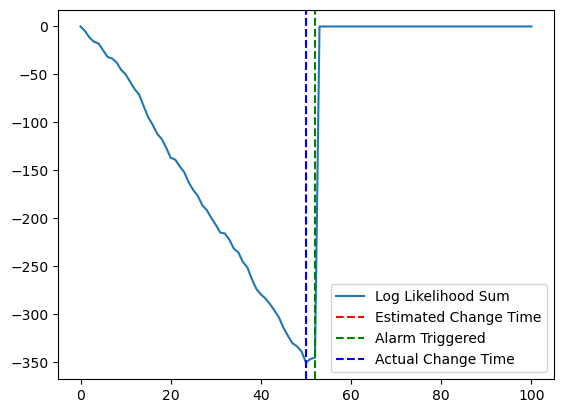

In [24]:
plt.plot(log_likelihood_sum, label='Log Likelihood Sum')
plt.axvline(x=change_time, color='r', linestyle='--', label='Estimated Change Time')
plt.axvline(x=alarm, color='g', linestyle='--', label='Alarm Triggered')
plt.axvline(x=50, color='b', linestyle='--', label='Actual Change Time')
plt.legend()
plt.show()

Alarms triggered at indices: [52, 104]


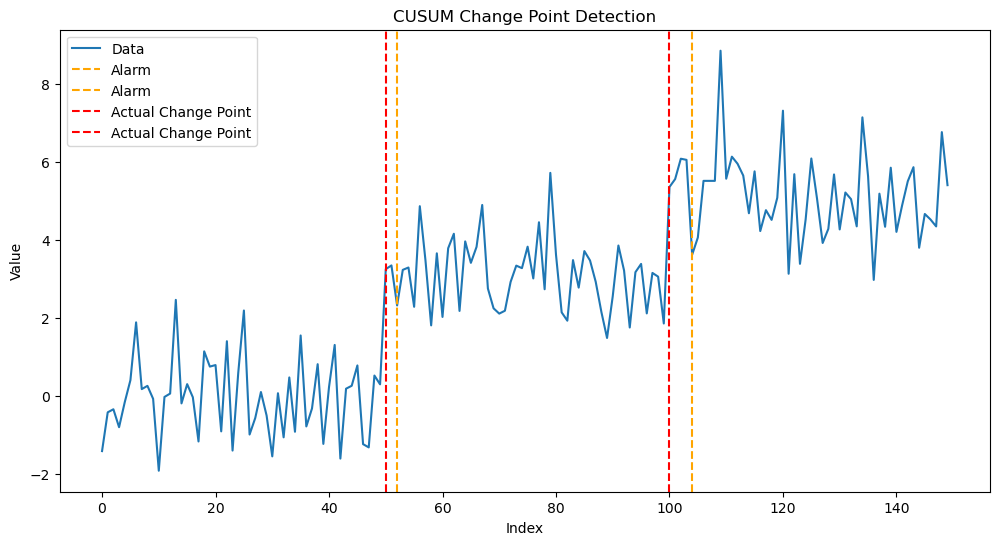

In [25]:
# Sequential change point detection
mu_vals = [0, 3, 5]
sigma_vals = [1, 1, 1]
data = np.concatenate([np.random.normal(mu_vals[0], sigma_vals[0], 50),
                       np.random.normal(mu_vals[1], sigma_vals[1], 50),
                       np.random.normal(mu_vals[2], sigma_vals[2], 50)])
alarms = cusum_detection_sequential(data, mu_vals, sigma_vals)
print(f"Alarms triggered at indices: {alarms}")
plot_cusum(data, estimated_change_times=None, alarms=alarms, actual_change_times=[50, 100])

In [26]:
# Performance evaluation
# Metrics used here are Detection Delay and Mean Time to False Alarm
def evaluate_mean_detection_delay(alarms, actual_change_times):
    """Evaluate the performance of the change point detection."""
    detection_delay = []

    for alarm in alarms:
        closest_change_time = min(actual_change_times, key=lambda x: abs(x - alarm))
        delay = abs(alarm - closest_change_time)
        detection_delay.append(delay)

    mean_detection_delay = np.mean(detection_delay) if detection_delay else 0

    return mean_detection_delay

In [27]:
def evaluate_estimation_performance(algorithm=cusum_detection_and_estimation):
    """Evaluate the performance of the change time estimation."""
    # Plot estimation performance against change in mean values
    mu_0 = 0
    errors = []
    for mu_1 in np.arange(1, 10, 1):
        data = np.concatenate([np.random.normal(mu_0, 1, 50), np.random.normal(mu_1, 1, 50)])
        change_time, alarm, log_likelihood_sum = algorithm(data, mu_0, 1, mu_1, 1)
        if change_time is np.inf:
            errors.append(100) # No change detected
        else:
            error = abs(change_time - 50)  # Assuming the change point is at index 50
            errors.append(error)
        print(f"Estimated Change Point: {change_time}, Error: {errors[-1]}, Alarm Triggered at: {alarm}")

    plt.plot(np.arange(1, 10, 1), errors, marker='o')
    plt.title('Change Point Estimation Performance')
    plt.xlabel('Change in Mean Value')
    plt.ylabel('Estimation Error')
    plt.grid()
    plt.show()
    return errors

In [28]:
def evaluate_mean_time_to_false_alarm(algorithm=cusum_detection_sequential):
    """Evaluate the mean time to false alarm."""
    # Generate synthetic data with no change points
    mean_time_to_false_alarm = 0.0
    np.random.seed(42)  # For reproducibility
    for _ in range(100):
        data = np.random.normal(0, 5, 100)
        alarms = algorithm(data, [0, 3], [5, 5])
        if alarms:
            mean_time_to_false_alarm += np.mean(alarms)/float(len(alarms))

    return mean_time_to_false_alarm/100.0

In [29]:
evaluate_mean_detection_delay(alarms, [50, 100])

np.float64(3.0)

Estimated Change Point: inf, Error: 100, Alarm Triggered at: None
Estimated Change Point: 63, Error: 13, Alarm Triggered at: 67
Estimated Change Point: 50, Error: 0, Alarm Triggered at: 51
Estimated Change Point: 50, Error: 0, Alarm Triggered at: 51
Estimated Change Point: 50, Error: 0, Alarm Triggered at: 51
Estimated Change Point: 50, Error: 0, Alarm Triggered at: 51
Estimated Change Point: 50, Error: 0, Alarm Triggered at: 51
Estimated Change Point: 50, Error: 0, Alarm Triggered at: 51
Estimated Change Point: 50, Error: 0, Alarm Triggered at: 51


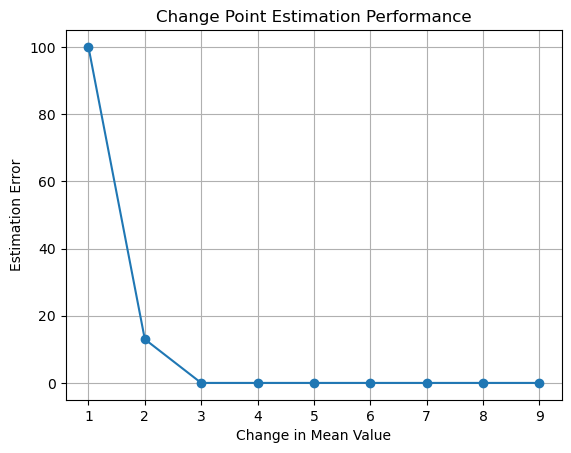

Mean Time to False Alarm: 0.0


In [30]:
evaluate_estimation_performance(algorithm=cusum_detection_and_estimation)
mean_time_to_false_alarm = evaluate_mean_time_to_false_alarm(algorithm=cusum_detection_sequential)
print(f"Mean Time to False Alarm: {mean_time_to_false_alarm}")

### Markov Process Change Detection

In [31]:
transition_probabilities_0 = np.zeros((5, 5))
decay = 0.5
for i in range(5):
    p = decay
    for j in range(i, 4):
        transition_probabilities_0[i, j] = p
        p *= decay
    transition_probabilities_0[i, 4] = 1 - np.sum(transition_probabilities_0[i, :4])
print("Transition Probabilities Matrix:")
print(transition_probabilities_0)

Transition Probabilities Matrix:
[[0.5    0.25   0.125  0.0625 0.0625]
 [0.     0.5    0.25   0.125  0.125 ]
 [0.     0.     0.5    0.25   0.25  ]
 [0.     0.     0.     0.5    0.5   ]
 [0.     0.     0.     0.     1.    ]]


In [32]:
transition_probabilities_1 = np.ones((5, 5))* 0.2
print("Transition Probabilities Matrix for Second State:")
print(transition_probabilities_1)

Transition Probabilities Matrix for Second State:
[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]
